# The Battle of Neighborhoods - Greek Restaurants in NYC

## Introduction

New York City is a vast and diverse metropolis and is the largest city in the United States with a long history of global immigration. As of 2020 New York City is the home to nearly 8.7 million residents, accounting for almost 45% of the entire states populus. 

New York City has most notably been coined a "Melting Pot" dating back to the Ellis Island days of immigration. Over time and with an infusion of many diverse cultures this has lead to a great many restaurants from all the different cultures. Many of these different cultural restaurants include Italian, Chinese, Greek, Indian, French, etc.

For my project I would like to list and visualize all boroughs of New York City that contain amazing Greek cuisine. 

## Data

For this project we need the following data:

- New York City data that includes lists of boroughs and neighborhoods along with thier latitude and longitude
    - Data source: https://cocl.us/new_york_dataset
    - Description: This data set contains all the information needed for the boroughs and neighborhoods of New York City.
- Greek restaurants in each neighborhood of New York City
    - Data source: Foursquare API
    - Description: By using the API we can get all the venue data of New York City and then filter out the Greek restaurants.

## Approach

- Collect New York City data from https://cocl.us/new_york_dataset
- Use FourSquare API to find all the venues in each borough and neighborhood
- Filter out all the venues that are Greek restaurants
- Find ratings, tips, and like counts for the Greek restaurants using FourSquare API
- Using ratings for each restaurant we can sort the data
- Vizualize the ranking of neighborhoods using folium library

## Questions

- What is the best location in New York City for Greek cuisine?
- Which areas have a potential Greek restaurant market?
- Which areas lack Greek restaurants?

In [1]:
# Import libraries
import numpy as np # data in a vectorized manner manipulation
import pandas as pd # data analsysis
import requests # HTTP library
from bs4 import BeautifulSoup # scraping library

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json # JSON files manipulation

from sklearn.cluster import KMeans # clustering algorithm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print("Library Loaded")

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Library Loaded


Now we define a function to get the latitude and longitude of a given location using geopy

In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 meters for a given latitude and longitude. Below function will return us the venue id, venue name, and category.

In [3]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'SRJXUY2TVHWJAGG34XO0OIYVRAPGBCZNVAFGKUCB2J1GURA3' # your Foursquare ID
    CLIENT_SECRET = 'RCZXIVEPGZOCGJ0EQVVLVJXCAJTXJP55YUYPTNCAEL1CX0VK' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we will define a function to get venue details rating, tips, and count for a given venue id. This will be used for ranking.

In [4]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'SRJXUY2TVHWJAGG34XO0OIYVRAPGBCZNVAFGKUCB2J1GURA3' # your Foursquare ID
    CLIENT_SECRET = 'RCZXIVEPGZOCGJ0EQVVLVJXCAJTXJP55YUYPTNCAEL1CX0VK' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we define a funtion to get the New York City data such as boroughs and neighborhoods.

In [5]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [6]:
# get new york data
new_york_data=get_new_york_data()

In [7]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
new_york_data.shape

(306, 4)

There are total of 306 different Neighborhoods in New York City

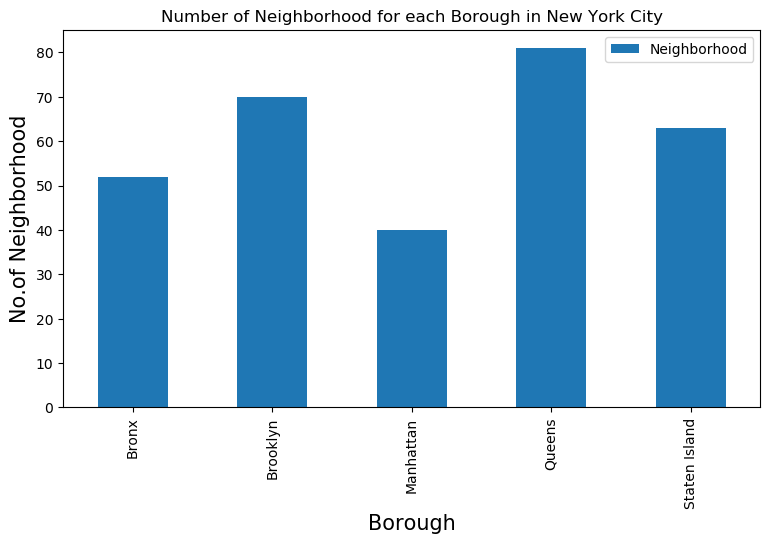

In [9]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We are able to see that Queens has the highest number of neighborhoods. We will now filter out Greek restaurants for each neighborhood.

In [10]:
# prepare neighborhood list that contains greek resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
greek_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    greek_resturants=venues[venues['Category']=='Greek Restaurant']   
    print('(',count,'/',len(new_york_data),')','Greek Resturants in '+Neighborhood+', '+Borough+':'+str(len(greek_resturants)))
    for resturant_detail in greek_resturants.values.tolist():
        id, name , category=resturant_detail
        greek_rest_ny = greek_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Greek Resturants in Wakefield, Bronx:0
( 2 / 306 ) Greek Resturants in Co-op City, Bronx:0
( 3 / 306 ) Greek Resturants in Eastchester, Bronx:0
( 4 / 306 ) Greek Resturants in Fieldston, Bronx:1
( 5 / 306 ) Greek Resturants in Riverdale, Bronx:1
( 6 / 306 ) Greek Resturants in Kingsbridge, Bronx:1
( 7 / 306 ) Greek Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Greek Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Greek Resturants in Norwood, Bronx:0
( 10 / 306 ) Greek Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Greek Resturants in Baychester, Bronx:0
( 12 / 306 ) Greek Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Greek Resturants in City Island, Bronx:0
( 14 / 306 ) Greek Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Greek Resturants in University Heights, Bronx:0
( 16 / 306 ) Greek Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Greek Resturants in Fordham, Bronx:0
( 18 / 306 ) Greek Resturants in East Tremont, Bronx:0
( 19 / 306 ) Greek Resturants in W

In [11]:
greek_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Fieldston,4bc39d1d2a89ef3bdf49f588,Greek Express
1,Bronx,Riverdale,4bc39d1d2a89ef3bdf49f588,Greek Express
2,Bronx,Kingsbridge,4bc39d1d2a89ef3bdf49f588,Greek Express
3,Brooklyn,Bay Ridge,58fa85be98fbfc397bafe21f,Blue Door Souvlakia
4,Brooklyn,Bay Ridge,4bbce66da0a0c9b6b9f41a0f,Elia Restaurant


In [12]:
greek_rest_ny.shape

(82, 4)

We are able to see that there are 82 Greek restaurants in New York City.

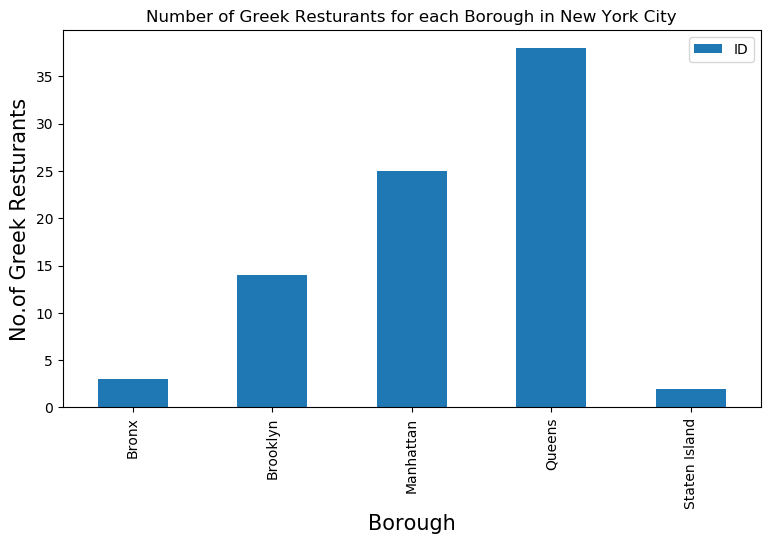

In [13]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Greek Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Greek Resturants', fontsize=15)
#giving a bar plot
greek_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Queens has the highest number of Greek restaurants

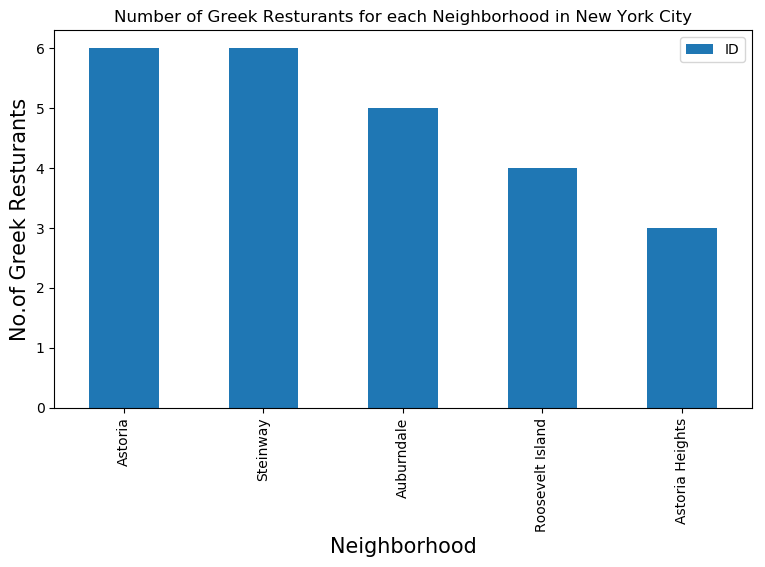

In [14]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Greek Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Greek Resturants', fontsize=15)
#giving a bar plot
greek_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [15]:
greek_rest_ny[greek_rest_ny['Neighborhood']=='Astoria']

,Borough,Neighborhood,ID,Name
33,Queens,Astoria,4aa840a9f964a520665020e3,Ovelia Psistaria Bar
34,Queens,Astoria,4ba406b6f964a520317938e3,Crave Astoria
35,Queens,Astoria,553ffa91498e2c76f06c0c03,SVL Bar
36,Queens,Astoria,4a7b0eb5f964a520e5e91fe3,BZ Grill
37,Queens,Astoria,59f3b0a2dee770670b00c0a1,Gyro World
38,Queens,Astoria,4b0b36a5f964a520cb2e23e3,Gyro Uno


In [16]:
greek_rest_ny[greek_rest_ny['Neighborhood']=='Steinway']

,Borough,Neighborhood,ID,Name
52,Queens,Steinway,4b491ca9f964a520586626e3,Loukoumi Taverna
53,Queens,Steinway,4a8e20edf964a520131220e3,Taverna Kyclades
54,Queens,Steinway,4a9b2269f964a520863420e3,Stamatis
55,Queens,Steinway,48a7dcf0f964a520a0511fe3,Telly's Taverna
56,Queens,Steinway,4a5a425df964a52003ba1fe3,Zorba's Souvlaki Plus
57,Queens,Steinway,561a965b498e99e2d7512565,Dionysos Restaurant


Astoria and Steinway have the highstamount of Greek restaurants. For this project I chose to delve into Astoria.

Now we will get all the rankings of the restaurants 

In [17]:
# prepare neighborhood list that contains greek resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
greek_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in greek_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(greek_rest_ny),')','processed')
    greek_rest_stats_ny = greek_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID           Name  Likes  Rating  Tips
0  4bc39d1d2a89ef3bdf49f588  Greek Express     32     8.2    16
( 1 / 82 ) processed
                         ID           Name  Likes  Rating  Tips
0  4bc39d1d2a89ef3bdf49f588  Greek Express     32     8.2    16
( 2 / 82 ) processed
                         ID           Name  Likes  Rating  Tips
0  4bc39d1d2a89ef3bdf49f588  Greek Express     32     8.2    16
( 3 / 82 ) processed
                         ID                 Name  Likes  Rating  Tips
0  58fa85be98fbfc397bafe21f  Blue Door Souvlakia      8     7.6     6
( 4 / 82 ) processed
                         ID             Name  Likes  Rating  Tips
0  4bbce66da0a0c9b6b9f41a0f  Elia Restaurant     10     7.7    12
( 5 / 82 ) processed
                         ID             Name  Likes  Rating  Tips
0  4bca37a60687ef3b1a96dbcc  Something Greek     26     7.3    15
( 6 / 82 ) processed
                         ID    Name  Likes  Rating  Tips
0  4bdc6a0d3904a593f7104e9e  

In [18]:
greek_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Fieldston,4bc39d1d2a89ef3bdf49f588,Greek Express,32,8.2,16
1,Bronx,Riverdale,4bc39d1d2a89ef3bdf49f588,Greek Express,32,8.2,16
2,Bronx,Kingsbridge,4bc39d1d2a89ef3bdf49f588,Greek Express,32,8.2,16
3,Brooklyn,Bay Ridge,58fa85be98fbfc397bafe21f,Blue Door Souvlakia,8,7.6,6
4,Brooklyn,Bay Ridge,4bbce66da0a0c9b6b9f41a0f,Elia Restaurant,10,7.7,12


In [19]:
greek_rest_stats_ny.shape

(82, 7)

In [20]:
greek_rest_ny.shape

(82, 4)

We now have the data for all the resturants. Lets save this data to a csv sheet in case we mistakenly modify it. 

In [21]:
greek_rest_stats_ny.to_csv('greek_rest_stats_ny.csv', index=False)

In [22]:
greek_rest_stats_ny_csv=pd.read_csv('greek_rest_stats_ny.csv')

In [23]:
greek_rest_stats_ny_csv.shape

(82, 7)

In [24]:
greek_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Fieldston,4bc39d1d2a89ef3bdf49f588,Greek Express,32,8.2,16
1,Bronx,Riverdale,4bc39d1d2a89ef3bdf49f588,Greek Express,32,8.2,16
2,Bronx,Kingsbridge,4bc39d1d2a89ef3bdf49f588,Greek Express,32,8.2,16
3,Brooklyn,Bay Ridge,58fa85be98fbfc397bafe21f,Blue Door Souvlakia,8,7.6,6
4,Brooklyn,Bay Ridge,4bbce66da0a0c9b6b9f41a0f,Elia Restaurant,10,7.7,12


In [25]:
greek_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 7 columns):
Borough         82 non-null object
Neighborhood    82 non-null object
ID              82 non-null object
Name            82 non-null object
Likes           82 non-null object
Rating          82 non-null float64
Tips            82 non-null object
dtypes: float64(1), object(6)
memory usage: 4.6+ KB


We see that values likes and tips are strg values. We would need to convert them into float for further analysis

In [26]:
greek_rest_stats_ny['Likes']=greek_rest_stats_ny['Likes'].astype('float64')

In [27]:
greek_rest_stats_ny['Tips']=greek_rest_stats_ny['Tips'].astype('float64')

In [28]:
greek_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 7 columns):
Borough         82 non-null object
Neighborhood    82 non-null object
ID              82 non-null object
Name            82 non-null object
Likes           82 non-null float64
Rating          82 non-null float64
Tips            82 non-null float64
dtypes: float64(3), object(4)
memory usage: 4.6+ KB


In [29]:
# Resturant with maximum Likes
greek_rest_stats_ny.iloc[greek_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                   Chinatown
ID              5521c2ff498ebe2368634187
Name                              Kiki's
Likes                                831
Rating                               9.3
Tips                                 204
Name: 17, dtype: object

In [30]:
# Resturant with maximum Rating
greek_rest_stats_ny.iloc[greek_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                   Chinatown
ID              5521c2ff498ebe2368634187
Name                              Kiki's
Likes                                831
Rating                               9.3
Tips                                 204
Name: 17, dtype: object

In [31]:
# Resturant with maximum Tips
greek_rest_stats_ny.iloc[greek_rest_stats_ny['Tips'].idxmax()]

Borough                           Queens
Neighborhood                    Steinway
ID              4a8e20edf964a520131220e3
Name                    Taverna Kyclades
Likes                                632
Rating                               9.2
Tips                                 284
Name: 53, dtype: object

Now lets visualize neighborhoods with maximum average rating of restaurants

In [32]:
ny_neighborhood_stats=greek_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [33]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
8,Chinatown,9.30
45,Yorkville,9.00
18,Gramercy,9.00
37,Stuyvesant Town,9.00
12,East Village,8.95
28,Noho,8.85
25,Lower East Side,8.80
42,Upper West Side,8.80
4,Bayside,8.75
22,Lenox Hill,8.70


Above are the top neighborhoods with top average rating of Greek restaurants

In [34]:
ny_borough_stats=greek_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [35]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.616000
0,Bronx,8.200000
1,Brooklyn,7.814286
3,Queens,7.526316
4,Staten Island,0.000000


these are the average ratings of Greek Resturants for each Borough

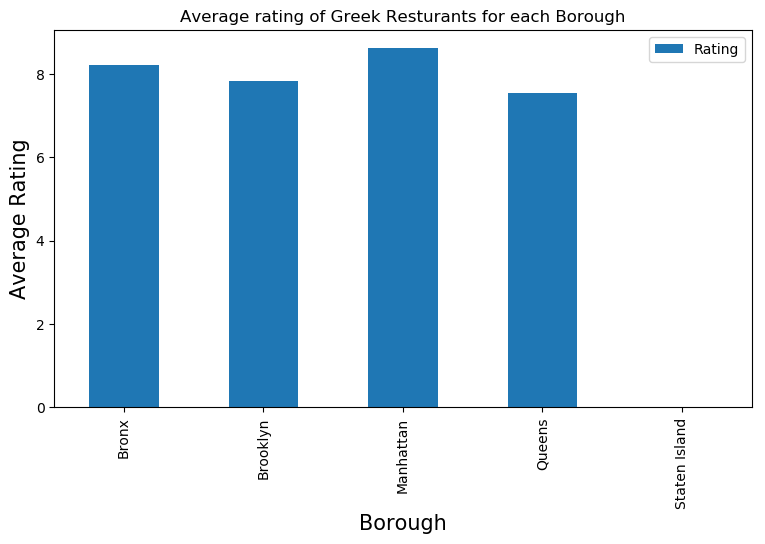

In [36]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Greek Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
greek_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 9.0 to visualize on the map

In [37]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]

In [38]:
ny_neighborhood_stats

,Neighborhood,Average Rating
8,Chinatown,9.3
18,Gramercy,9.0
37,Stuyvesant Town,9.0
45,Yorkville,9.0


In [39]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [40]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [41]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Chinatown,40.715618,-73.994279,9.3
1,Manhattan,Gramercy,40.737210,-73.981376,9.0
2,Manhattan,Stuyvesant Town,40.731000,-73.974052,9.0
3,Manhattan,Yorkville,40.775930,-73.947118,9.0


In [42]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [43]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [44]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [45]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

# Conclusion

- Even though Queens had the most Greek restaurants they did not have the highest average rating, Manhatten did.
- Manhattan specifically Chinatown, Gramercy, Stuyvesant Town, and Yorkville are some of the best neighborhoods for Greek Cuisine.
- Manhatten also has the bets potential for a Greek restaurant market.
- Staten Island ranks last in average rating for Greek restaurants.

# Limitations

- The rankings are purely based off of the ratings of restuarants
- The accuracy of the data is based upon the data provided by FourSquare.